In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from Paper
    model = conv2DNet_4(Noutputs)  #from Temporal - Spatial; 4 Filters Model
    #model = conv2DNet_5(Noutputs) #from Temporal - Spatial; 64 Filters Model
    #model = conv2DNet_6(Noutputs) #from Temporal - Spatial; 128 Filters Model
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  66.56666666666666
	 Validation accuracy  41.875
	 Test accuracy  49.2
	 Epoch Loss  134.4981231689453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  79.13333333333334
	 Validation accuracy  54.375
	 Test accuracy  72.9
	 Epoch Loss  117.34418487548828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  84.7
	 Validation ac

Epoch Number :  23
	 Training accuracy:  95.7
	 Validation accuracy  83.125
	 Test accuracy  78.4
	 Epoch Loss  75.92082214355469
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  96.83333333333333
	 Validation accuracy  80.0
	 Test accuracy  80.1
	 Epoch Loss  68.7100830078125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  96.6
	 Validation accuracy  81.875
	 Test accuracy  79.2
	 Epoch Loss  69.899658203125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
d

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.56666666666666
	 Validation accuracy  80.625
	 Test accuracy  78.4
	 Epoch Loss  67.33789825439453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.56666666666666
	 Validation accuracy  80.625
	 Test accuracy  78.4
	 Epoch Loss  67.33599090576172
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  97.56666666666666
	 Validation 

Epoch Number :  20
	 Training accuracy:  97.63333333333334
	 Validation accuracy  74.375
	 Test accuracy  73.5
	 Epoch Loss  67.58721160888672
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  95.5
	 Validation accuracy  75.0
	 Test accuracy  76.8
	 Epoch Loss  69.11890411376953
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  97.56666666666666
	 Validation accuracy  77.5
	 Test accuracy  74.4
	 Epoch Loss  68.11334991455078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  98.46666666666667
	 Validation accuracy  77.5
	 Test accuracy  75.1
	 Epoch Loss  65.4715576171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  98.43333333333334
	 Validation accuracy  77.5
	 Test accuracy  75.0
	 Epoch Loss  65.4617919921875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  98.43333333333334
	 Validation accura

Epoch Number :  17
	 Training accuracy:  89.46666666666667
	 Validation accuracy  78.75
	 Test accuracy  78.7
	 Epoch Loss  67.903076171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  98.0
	 Validation accuracy  76.25
	 Test accuracy  79.6
	 Epoch Loss  67.24173736572266
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  98.23333333333333
	 Validation accuracy  76.25
	 Test accuracy  78.7
	 Epoch Loss  66.27770233154297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.26666666666667
	 Validation accuracy  76.875
	 Test accuracy  78.4
	 Epoch Loss  66.00482940673828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  98.3
	 Validation accuracy  76.875
	 Test accuracy  78.3
	 Epoch Loss  66.0029525756836
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  98.3
	 Validation accuracy  76.875
	 Test acc

Epoch Number :  14
	 Training accuracy:  94.66666666666667
	 Validation accuracy  71.25
	 Test accuracy  81.4
	 Epoch Loss  70.02833557128906
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  91.66666666666667
	 Validation accuracy  73.125
	 Test accuracy  76.4
	 Epoch Loss  70.51866912841797
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  96.7
	 Validation accuracy  75.0
	 Test accuracy  78.4
	 Epoch Loss  73.09627532958984
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  96.96666666666667
	 Validation accuracy  72.5
	 Test accuracy  76.7
	 Epoch Loss  73.86490631103516
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  97.16666666666667
	 Validation accuracy  73.75
	 Test accuracy  76.9
	 Epoch Loss  68.39522552490234
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  97.23333333333333
	 Validation acc

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  95.3
	 Validation accuracy  76.25
	 Test accuracy  76.2
	 Epoch Loss  70.59072875976562
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  94.53333333333333
	 Validation accuracy  75.625
	 Test accuracy  79.8
	 Epoch Loss  69.76905822753906
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  96.3
	 Validation accuracy  78.125
	 Test accuracy  76.6
	 Epoch Loss  71.22565460205078
data_target torch.Size([3000

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  83.2
	 Validation accuracy  75.625
	 Test accuracy  71.7
	 Epoch Loss  68.7903060913086
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  89.4
	 Validation accuracy  79.375
	 Test accuracy  78.3
	 Epoch Loss  75.94441986083984
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  96.96666666666667
	 Validation accuracy  76.25
	 Test accu

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  95.0
	 Validation accuracy  80.0
	 Test accuracy  79.1
	 Epoch Loss  82.93333435058594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  93.56666666666666
	 Validation accuracy  69.375
	 Test accuracy  79.2
	 Epoch Loss  82.94123077392578
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  96.63333333333334
	 Validation accuracy  74.375

Epoch Number :  32
	 Training accuracy:  98.23333333333333
	 Validation accuracy  78.125
	 Test accuracy  78.7
	 Epoch Loss  67.3608627319336
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  98.2
	 Validation accuracy  78.125
	 Test accuracy  78.2
	 Epoch Loss  67.24768829345703
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  98.23333333333333
	 Validation accuracy  77.5
	 Test accuracy  80.1
	 Epoch Loss  67.14199829101562
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  94.8
	 Validation accuracy  75.0
	 Test accuracy  74.4
	 Epoch Loss  74.65703582763672
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  94.96666666666667
	 Validation accuracy  77.5
	 Test accuracy  74.9
	 Epoch Loss  73.01272583007812
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  95.5
	 Validation accuracy  76.25
	 Test accuracy  

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  98.33333333333333
	 Validation accuracy  75.0
	 Test accuracy  77.0
	 Epoch Loss  66.07585906982422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  98.33333333333333
	 Validation accuracy  75.0
	 Test accuracy  77.1
	 Epoch Loss  66.06978607177734
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  98.3
	 Validation accuracy  75.0
	 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  92.16666666666667
	 Validation accuracy  90.0
	 Test accuracy  77.2
	 Epoch Loss  84.91602325439453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  93.93333333333334
	 Validation accuracy  86.25
	 Test accuracy  79.5
	 Epoch Loss  78.70143127441406
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  94.1
	 Validation accuracy  86.875
	 Test accuracy  78.9
	 Epoch Loss  77.18560791015625
data_target torch.Si

Epoch Number :  26
	 Training accuracy:  97.83333333333333
	 Validation accuracy  83.75
	 Test accuracy  83.6
	 Epoch Loss  66.6893539428711
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  93.33333333333333
	 Validation accuracy  86.25
	 Test accuracy  79.5
	 Epoch Loss  75.63851928710938
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  94.2
	 Validation accuracy  83.75
	 Test accuracy  83.5
	 Epoch Loss  70.9281234741211
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  68.46666666666667
	 Validation accuracy  62.5
	 Test accuracy  50.4
	 Epoch Loss  135.5657958984375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  81.43333333333334
	 Validation accuracy  65.0
	 Test accuracy  65.8
	 Epoch Loss  121.046630859375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  86.73333333333333
	 Validation accuracy

Epoch Number :  23
	 Training accuracy:  97.66666666666667
	 Validation accuracy  75.0
	 Test accuracy  77.4
	 Epoch Loss  66.84963989257812
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  97.76666666666667
	 Validation accuracy  75.0
	 Test accuracy  77.1
	 Epoch Loss  66.78045654296875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.7
	 Validation accuracy  75.0
	 Test accuracy  76.6
	 Epoch Loss  66.75565338134766
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Si

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  98.2
	 Validation accuracy  78.75
	 Test accuracy  77.7
	 Epoch Loss  65.99832916259766
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  98.2
	 Validation accuracy  78.75
	 Test accuracy  77.6
	 Epoch Loss  65.99765014648438
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.2
	 Validation accuracy  80.0
	 Test accuracy  77.6
	 Ep

Epoch Number :  20
	 Training accuracy:  97.93333333333334
	 Validation accuracy  81.25
	 Test accuracy  73.3
	 Epoch Loss  65.55589294433594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  99.1
	 Validation accuracy  73.75
	 Test accuracy  75.7
	 Epoch Loss  64.59390258789062
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  99.46666666666667
	 Validation accuracy  76.875
	 Test accuracy  74.1
	 Epoch Loss  64.18780517578125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  99.56666666666666
	 Validation accuracy  76.25
	 Test accuracy  72.9
	 Epoch Loss  63.55891418457031
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  99.56666666666666
	 Validation accuracy  76.25
	 Test accuracy  72.8
	 Epoch Loss  63.54596710205078
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  99.56666666666666
	 Validation ac

torch.Size([10, 50])
0


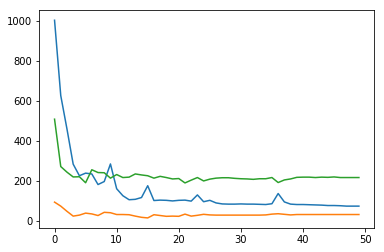

1


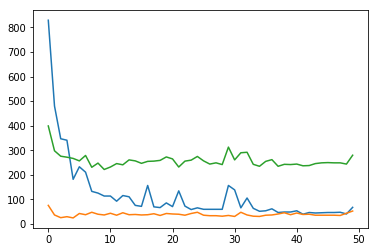

2


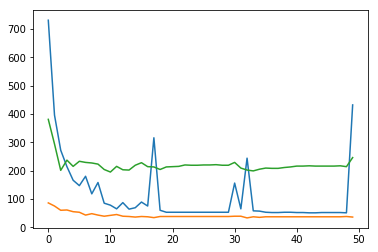

3


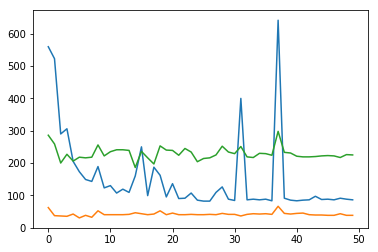

4


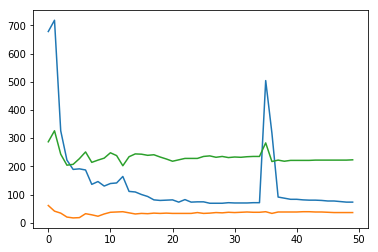

5


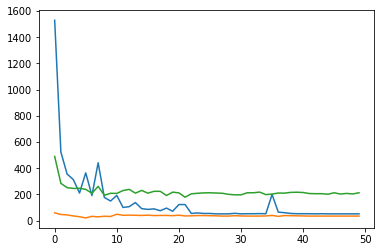

6


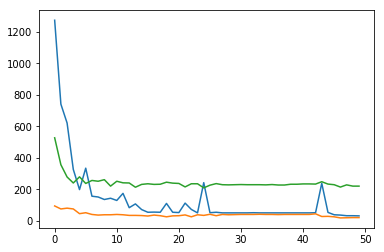

7


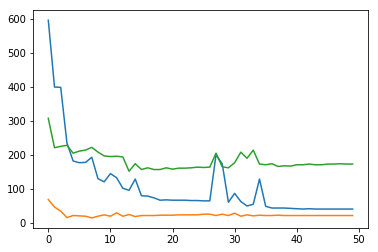

8


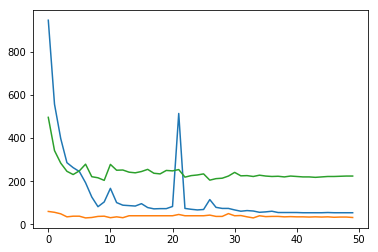

9


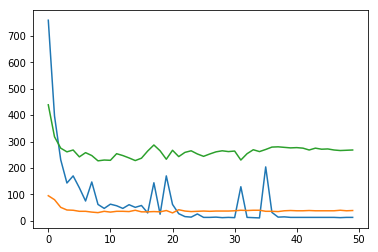

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


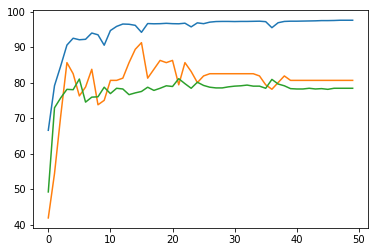

1


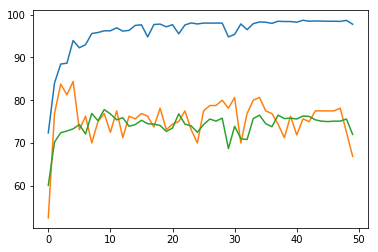

2


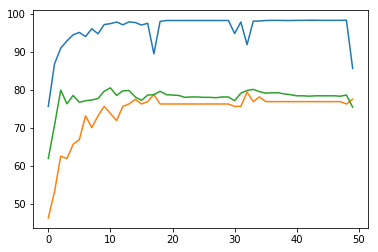

3


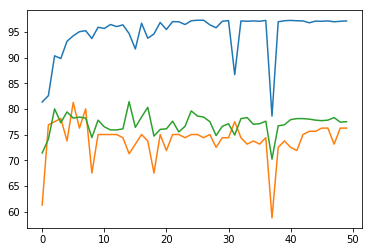

4


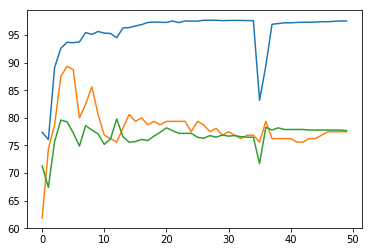

5


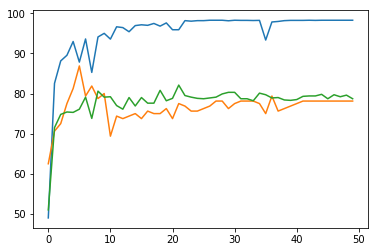

6


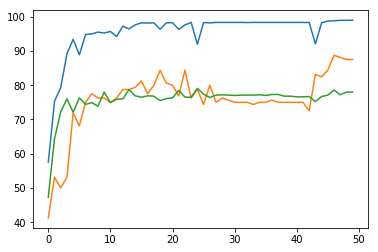

7


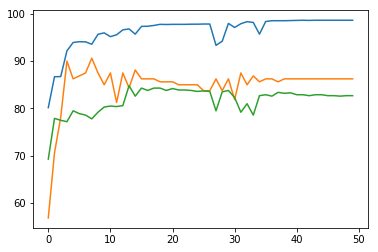

8


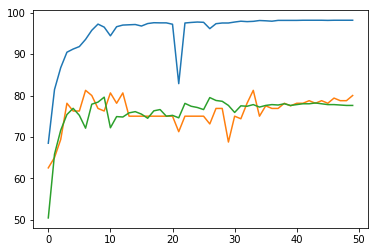

9


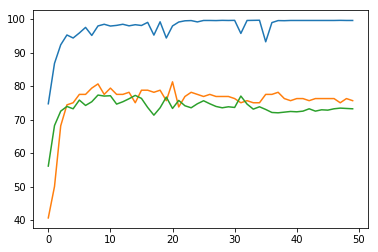

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 96.9%+-3.8375356197357178
Validation accuracy 78.6%+-5.461513042449951
Testing accuracy 77.1%+-2.8512449264526367


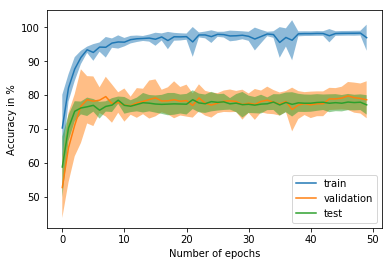

In [9]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))